In [132]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from conf_dict_util import conf_to_dict, dict_to_conf
from qoe_utils import make_bandwidth_series, get_QoE_rr, get_QoE_delay, get_QoE_losses
from best_algs import one_conf_models_dict

In [133]:
traces = [
          "WIRED_900kbps",
          "WIRED_35mbps",
          "WIRED_200kbps", 
          "4G_700kbps",
          "4G_3mbps",
          "4G_500kbps",
          "5G_12mbps",
          "5G_13mbps",
          "trace_300k",
]


In [135]:
## Best single configuration for all
from best_algs import one_conf_models_dict
list_conf_names = [d[200] for d in one_conf_models_dict.values()]
print("Len list_conf_names: ", len(list_conf_names)) 

Len list_conf_names:  9


In [136]:
# conf_general_name = "TD3_delay_True_tuned_False"
# list_conf_names = ['TD3_4G_3mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22', 'TD3_4G_500kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22', 'TD3_4G_700kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22', 'TD3_5G_12mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22', 'TD3_5G_13mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22', 'TD3_WIRED_200kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22', 'TD3_WIRED_35mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22', 'TD3_WIRED_900kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22', 'TD3_trace_300k_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22']

In [137]:
plot_rr = False
plot_delay = False

prefix = "../output_mp/rates_delay_loss_"
suffix = ".pickle"
result_qoe = []


for conf_name in list_conf_names:
    

    d = conf_to_dict(conf_name)
    
    print("Input model: ", conf_name, " trained on trace: ", d["trace_name"])

    time_step = d["step_time"]
    reward_profile = d["reward_profile"]
    delay_states = d["delay_states"]
    normalize_states = d["normalize_states"]
    alg_name = d["alg"]

    dict_result = {}
    name = d["trace_name"]
    REAL_NAME = d["trace_name"]

    #Read rates_delay_loss and make l_rate
    pickle_path = prefix+conf_name+suffix
    if not os.path.exists(pickle_path):
        print("Conf doesn't exist: ", conf_name)
        print("--------------------------")
        continue
    
    l_rate = pd.read_pickle(pickle_path)

    pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{REAL_NAME}.pickle"
    l_rate_gcc = pd.read_pickle(pickle_path_gcc)
    trace_name = l_rate_gcc["trace_name"]
    if trace_name != REAL_NAME:
        print("Does not coincide with GCC pickle!")
        
    dict_result["trace"] = REAL_NAME
    
    #QoE rr
    U, U_gcc = get_QoE_rr(l_rate, l_rate_gcc, REAL_NAME, time_step)
    # print(name, "reward profile: ", d["reward_profile"])
    qoe_rr = 100*U.quantile(0.5)
    qoe_rr_gcc = 100*U_gcc.quantile(0.5)
    # print("QoE rr:", f"RL: {round(qoe_rr,2)}, GCC: {round(qoe_rr_gcc,2)}")
    if plot_rr:
        plot_cdf_multiple([U, U_gcc], "bandwidth_util", legend=["RL", "GCC"], figsize=(4,2))
        plt.show()
        
    dict_result["qoe_rr"] = qoe_rr
    dict_result["qoe_rr_gcc"] = qoe_rr_gcc

    #QoE delay
    delay, delay_gcc, qoe_delay, qoe_delay_gcc = get_QoE_delay(l_rate, l_rate_gcc, REAL_NAME, time_step)
    # print("QoE delay:", f"RL: {round(qoe_delay,2)}, GCC: {round(qoe_delay_gcc,2)}")
    if plot_delay:
        plot_cdf_multiple([delay, delay_gcc], "delay", legend=["RL", "GCC"], figsize=(4,2))
        plt.xlim(0,1000)
        plt.show()

    dict_result["qoe_delay"] = qoe_delay
    dict_result["qoe_delay_gcc"] = qoe_delay_gcc

    #QoE losses
    loss_ratio, loss_ratio_gcc, qoe_losses, qoe_losses_gcc = get_QoE_losses(l_rate, l_rate_gcc, REAL_NAME, time_step)
    # print("QoE loss:", f"RL: {round(qoe_losses,2)}, GCC: {round(qoe_losses_gcc,2)}")
    
    dict_result["qoe_losses"] = round(qoe_losses,2)
    dict_result["qoe_losses_gcc"] = round(qoe_losses_gcc,2)

    #Overall QoE
    qoe = 0.333*qoe_rr + 0.333*qoe_delay + 0.333*qoe_losses
    qoe_gcc = 0.333*qoe_rr_gcc + 0.333*qoe_delay_gcc + 0.333*qoe_losses_gcc
    
    dict_result["qoe"] = qoe
    dict_result["qoe_gcc"] = qoe_gcc

    # print("Overall QoE:", f"RL: {round(qoe,2)}, GCC: {round(qoe_gcc,2)}")
    # print("---------")
    
    result_qoe.append(dict_result)
    
    if name == "4G_3mbps":
        loss_ratio_4G = loss_ratio
        delay_4G = delay
        loss_ratio_4G_gcc = loss_ratio_gcc
        delay_4G_gcc = delay_gcc

Input model:  TD3_WIRED_900kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22  trained on trace:  WIRED_900kbps
Input model:  TD3_WIRED_200kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22  trained on trace:  WIRED_200kbps
Input model:  TD3_WIRED_35mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22  trained on trace:  WIRED_35mbps
Input model:  TD3_4G_700kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22  trained on trace:  4G_700kbps
Input model:  TD3_4G_3mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22  trained on trace:  4G_3mbps
Input model:  TD3_4G_500kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22  trained on trace:  4G_500kbps
Input model:  TD3_5G_12mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22  trained on trace:  5G_12mbps
Input model:  TD3_5G_13mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_

## Plot QoE results

In [138]:
df = pd.DataFrame(result_qoe)
df

,trace,qoe_rr,qoe_rr_gcc,qoe_delay,qoe_delay_gcc,qoe_losses,qoe_losses_gcc,qoe,qoe_gcc
0,WIRED_900kbps,86.264151,92.940000,71.524781,38.369154,100.00,100.00,85.843714,77.025948
1,WIRED_200kbps,16.615385,93.782178,99.212034,82.472933,100.00,100.00,71.870531,91.992952
2,WIRED_35mbps,20.522474,8.657727,66.769298,66.513467,99.13,99.47,62.078382,58.155137
3,4G_700kbps,73.666340,59.770873,86.667891,89.756545,100.00,99.84,86.691299,83.039287
4,4G_3mbps,61.009910,12.322388,88.110951,96.791309,86.67,87.38,78.518148,65.432837
5,4G_500kbps,63.795585,78.806782,89.701290,76.254679,100.00,99.83,84.414460,84.877641
6,5G_12mbps,55.947957,4.189749,72.315734,85.380504,94.09,99.82,74.043047,63.068381
7,5G_13mbps,16.627788,5.214884,43.443026,55.831855,97.13,99.99,52.348260,53.623630
8,trace_300k,90.720000,99.213333,67.613636,10.488488,100.00,100.00,86.025101,69.830706


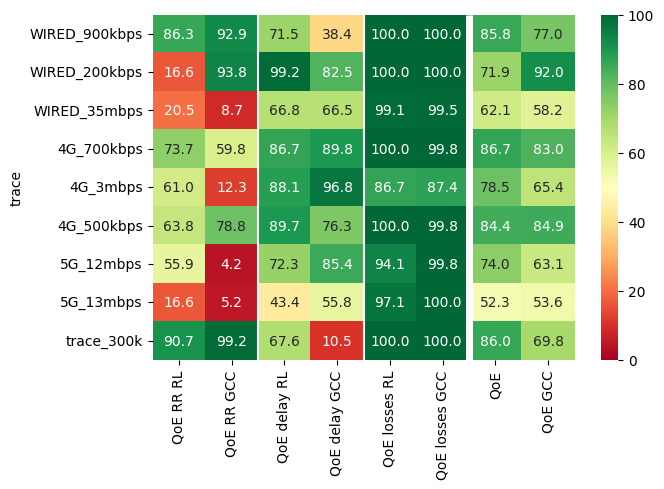

In [139]:
import seaborn as sns
plt.figure(figsize=(7,5))
ax = sns.heatmap(df.set_index("trace"), annot=True, fmt=".1f", cmap="RdYlGn",
                 cbar_kws={'ticks': [0, 20, 40, 60, 80, 100]}, vmin=0, vmax=100
                )
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], ["QoE RR RL", "QoE RR GCC", "QoE delay RL", "QoE delay GCC", "QoE losses RL", "QoE losses GCC", "QoE", "QoE GCC"])
ax.vlines([2, 4], *ax.get_ylim(), color="white")
ax.vlines([6], *ax.get_ylim(), color="white", lw=5)
plt.tight_layout()
plt.savefig(f"plots/same_conf/heatmap_QoE_same_conf_{conf_general_name}.png")

In [140]:
df_start = df.set_index("trace").drop(["qoe", "qoe_gcc"], axis=1)

In [141]:
import pandas as pd
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.5, 1))

x = df_start["qoe_losses"].values.reshape(-1, 1) #returns a numpy array
x_scaled = min_max_scaler.fit_transform(x)

x2 = df_start["qoe_losses_gcc"].values.reshape(-1, 1)
x_scaled_gcc = min_max_scaler.fit_transform(x2)

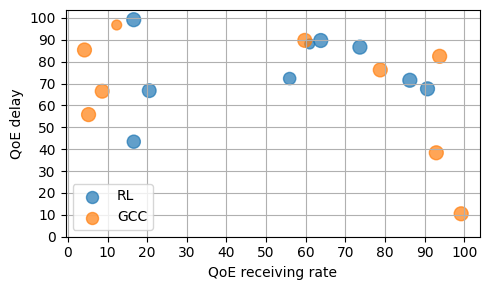

In [142]:
plt.figure(figsize=(5,3))
plt.scatter(df_start["qoe_rr"], df_start["qoe_delay"], s=x_scaled*100, label="RL", alpha=0.7)
# plt.scatter(2.6, 72)
plt.scatter(df_start["qoe_rr_gcc"], df_start["qoe_delay_gcc"], s=x_scaled_gcc*100, label="GCC", alpha=0.7)
plt.xlabel("QoE receiving rate")
plt.ylabel("QoE delay")
plt.grid()
plt.xticks(range(0,110,10), range(0,110,10))
plt.yticks(range(0,110,10), range(0,110,10))
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/same_conf/scatterplot_QoE_same_conf_{conf_general_name}.png")